ライブラリを指定する

In [1]:
%matplotlib inline

import sys
from urllib.request import urlretrieve
import zipfile
from dateutil.parser import parse
import json
from random import shuffle
import random
import datetime
import os

import boto3
import s3fs
import sagemaker
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from ipywidgets import IntSlider, FloatSlider, Checkbox

シード値設定

In [2]:
np.random.seed(42)
random.seed(42)

In [3]:
sagemaker_session = sagemaker.Session()

AWSのデータストレージサービスS3に「sagemaker」という文字列を含めたバケット名のバケットにデータ等を置き、ノートブックを立ち上げる時にそのS3バケット名を指定する。

In [4]:
s3_bucket = 'sagemaker-itoc'
s3_prefix = 'itoc'

role = sagemaker.get_execution_role()

In [5]:
region = sagemaker_session.boto_region_name
 
s3_data_path = "s3://{}/{}/data".format(s3_bucket, s3_prefix)
s3_output_path = "s3://{}/{}/output".format(s3_bucket, s3_prefix)

起動するコンテナイメージを指定する。

In [6]:
image_name = sagemaker.amazon.amazon_estimator.get_image_uri(region, "forecasting-deepar", "latest")

S3に置いた電力使用実績データを読み取る

In [7]:
df = pd.read_csv("s3n://{}/{}".format(s3_bucket, 'juyo-2017.csv'))

DATEとTIMEで別のカラムになっているので、一つに統合する

In [8]:
df['DATETIME'] = pd.to_datetime(df['DATE']+' '+df["TIME"])

In [9]:
df = df.drop(columns=['DATE', 'TIME']).set_index('DATETIME')

In [10]:
df.head()

,実績(万kW)
DATETIME,
2017-04-01 00:00:00,654
2017-04-01 01:00:00,660
2017-04-01 02:00:00,685
2017-04-01 03:00:00,706
2017-04-01 04:00:00,696


2時間の平均になるように変換する

In [11]:
num_timeseries = df.shape[1]
data_kw = df.resample('2H').sum() / 2
timeseries = []
for i in range(num_timeseries):
    timeseries.append(np.trim_zeros(data_kw.iloc[:,i], trim='f'))

1週間分のデータをプロットしてみる

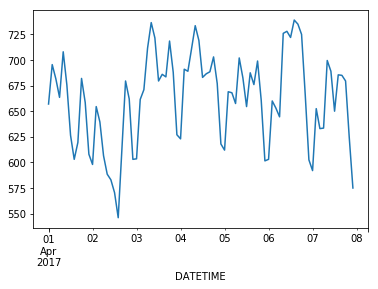

In [12]:
timeseries[0].loc["2017-04-01":"2017-04-07"].plot()

### トレーニングデータとテストデータに分ける

In [13]:
# データの時間間隔
freq = '2H'

# どれだけ先まで予測するか、2時間毎なので 7(日) × 12(1日分)
prediction_length = 7 * 12

# 学習時にどれだけの長さを使うか
context_length = 7 * 12

トレーニングデータとテストデータに分ける

In [14]:
start_dataset = pd.Timestamp("2017-04-01 00:00:00", freq=freq)
end_training = pd.Timestamp("2017-12-01 00:00:00", freq=freq)

In [15]:
training_data = [
    {
        "start": str(start_dataset),
        "target": ts[start_dataset:end_training - 1].tolist()  # We use -1, because pandas indexing includes the upper bound 
    }
    for ts in timeseries
]

In [16]:
num_test_windows = 4

test_data = [
    {
        "start": str(start_dataset),
        "target": ts[start_dataset:end_training + k * prediction_length].tolist()
    }
    for k in range(1, num_test_windows + 1) 
    for ts in timeseries
]

DeepAR向けに入力がJSON Lines形式となるように変更

In [17]:
def write_dicts_to_file(path, data):
    with open(path, 'wb') as fp:
        for d in data:
            fp.write(json.dumps(d).encode("utf-8"))
            fp.write("\n".encode('utf-8'))

In [18]:
%%time
write_dicts_to_file("train.json", training_data)
write_dicts_to_file("test.json", test_data)

CPU times: user 5.13 ms, sys: 70 µs, total: 5.2 ms
Wall time: 5.05 ms


S3へデータをコピーするメソッドを定義

In [19]:
s3 = boto3.resource('s3')
def copy_to_s3(local_file, s3_path, override=False):
    assert s3_path.startswith('s3://')
    split = s3_path.split('/')
    bucket = split[2]
    path = '/'.join(split[3:])
    buk = s3.Bucket(bucket)
    
    if len(list(buk.objects.filter(Prefix=path))) > 0:
        if not override:
            print('File s3://{}/{} already exists.\nSet override to upload anyway.\n'.format(s3_bucket, s3_path))
            return
        else:
            print('Overwriting existing file')
    with open(local_file, 'rb') as data:
        print('Uploading file to {}'.format(s3_path))
        buk.put_object(Key=path, Body=data)

In [20]:
%%time
copy_to_s3("train.json", s3_data_path + "/train/train.json")
copy_to_s3("test.json", s3_data_path + "/test/test.json")

File s3://sagemaker-itoc/s3://sagemaker-itoc/itoc/data/train/train.json already exists.
Set override to upload anyway.

File s3://sagemaker-itoc/s3://sagemaker-itoc/itoc/data/test/test.json already exists.
Set override to upload anyway.

CPU times: user 23.7 ms, sys: 0 ns, total: 23.7 ms
Wall time: 67.1 ms


In [21]:
s3filesystem = s3fs.S3FileSystem()
with s3filesystem.open(s3_data_path + "/train/train.json", 'rb') as fp:
    print(fp.readline().decode("utf-8")[:100] + "...")

{"start": "2017-04-01 00:00:00", "target": [654, 660, 685, 706, 696, 667, 665, 662, 689, 727, 680, 6...


### モデル作成

In [22]:
estimator = sagemaker.estimator.Estimator(
    sagemaker_session=sagemaker_session,
    image_name=image_name,
    role=role,
    train_instance_count=1,
    train_instance_type='ml.c4.2xlarge',
    base_job_name='deepar-electricity-demo',
    output_path=s3_output_path
)

ハイパーパラメータの設定

In [23]:
hyperparameters = {
    "time_freq": freq,
    "epochs": "80",
    "early_stopping_patience": "40",
    "mini_batch_size": "64",
    "learning_rate": "5E-4",
    "context_length": str(context_length),
    "prediction_length": str(prediction_length)
}

In [24]:
estimator.set_hyperparameters(**hyperparameters)

学習させる

In [25]:
%%time
data_channels = {
    "train": "{}/train/".format(s3_data_path),
    "test": "{}/test/".format(s3_data_path)
}

estimator.fit(inputs=data_channels, wait=True)

INFO:sagemaker:Creating training-job with name: deepar-electricity-demo-2019-03-04-06-41-26-931


2019-03-04 06:41:27 Starting - Starting the training job...
2019-03-04 06:41:28 Starting - Launching requested ML instances......
2019-03-04 06:42:31 Starting - Preparing the instances for training...
2019-03-04 06:43:22 Downloading - Downloading input data
2019-03-04 06:43:22 Training - Downloading the training image...
2019-03-04 06:43:55 Training - Training image download completed. Training in progress..
Arguments: train
[03/04/2019 06:43:57 INFO 140211577685824] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/default-input.json: {u'num_dynamic_feat': u'auto', u'dropout_rate': u'0.10', u'mini_batch_size': u'128', u'test_quantiles': u'[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'num_eval_samples': u'100', u'learning_rate': u'0.001', u'num_cells': u'40', u'num_layers': u'2', u'embedding_dimension': u'10', u'_kvstore': u'auto', u'_num_kv_servers': u'auto', u'cardinality': u'auto', u'like

[03/04/2019 06:44:16 INFO 140211577685824] processed a total of 620 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 2355.215072631836, "sum": 2355.215072631836, "min": 2355.215072631836}}, "EndTime": 1551681856.356896, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1551681854.001618}

[03/04/2019 06:44:16 INFO 140211577685824] #throughput_metric: host=algo-1, train throughput=263.231528322 records/second
[03/04/2019 06:44:16 INFO 140211577685824] #progress_metric: host=algo-1, completed 7 % of epochs
[03/04/2019 06:44:16 INFO 140211577685824] best epoch loss so far
[03/04/2019 06:44:16 INFO 140211577685824] Saved checkpoint to "/opt/ml/model/state_b99cb250-8541-49df-8254-cddca00ecc02-0000.params"
#metrics {"Metrics": {"state.serialize.time": {"count": 1, "max": 90.82317352294922, "sum": 90.82317352294922, "min": 90.82317352294922}}, "EndTime": 1551681856.448191, "Dimensions": {"Host": "algo-1", "Operation": "training

[03/04/2019 06:44:36 INFO 140211577685824] Epoch[13] Batch[5] avg_epoch_loss=5.173184
[03/04/2019 06:44:36 INFO 140211577685824] Epoch[13] Batch [5]#011Speed: 290.97 samples/sec#011loss=5.173184
[03/04/2019 06:44:37 INFO 140211577685824] processed a total of 615 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 2470.5309867858887, "sum": 2470.5309867858887, "min": 2470.5309867858887}}, "EndTime": 1551681877.08838, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1551681874.617784}

[03/04/2019 06:44:37 INFO 140211577685824] #throughput_metric: host=algo-1, train throughput=248.921559942 records/second
[03/04/2019 06:44:37 INFO 140211577685824] #progress_metric: host=algo-1, completed 17 % of epochs
[03/04/2019 06:44:37 INFO 140211577685824] loss did not improve
[03/04/2019 06:44:37 INFO 140211577685824] Epoch[14] Batch[0] avg_epoch_loss=5.115131
[03/04/2019 06:44:38 INFO 140211577685824] Epoch[14] Batch[5] avg_epoch_loss

[03/04/2019 06:44:56 INFO 140211577685824] Epoch[21] Batch[5] avg_epoch_loss=4.888950
[03/04/2019 06:44:56 INFO 140211577685824] Epoch[21] Batch [5]#011Speed: 298.62 samples/sec#011loss=4.888950
[03/04/2019 06:44:57 INFO 140211577685824] Epoch[21] Batch[10] avg_epoch_loss=4.872114
[03/04/2019 06:44:57 INFO 140211577685824] Epoch[21] Batch [10]#011Speed: 294.80 samples/sec#011loss=4.851910
[03/04/2019 06:44:57 INFO 140211577685824] processed a total of 708 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 2912.8379821777344, "sum": 2912.8379821777344, "min": 2912.8379821777344}}, "EndTime": 1551681897.877205, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1551681894.964045}

[03/04/2019 06:44:57 INFO 140211577685824] #throughput_metric: host=algo-1, train throughput=243.051915843 records/second
[03/04/2019 06:44:57 INFO 140211577685824] #progress_metric: host=algo-1, completed 27 % of epochs
[03/04/2019 06:44:57 INFO 14

[03/04/2019 06:45:15 INFO 140211577685824] Epoch[28] Batch[10] avg_epoch_loss=4.815434
[03/04/2019 06:45:15 INFO 140211577685824] Epoch[28] Batch [10]#011Speed: 291.11 samples/sec#011loss=4.768354
[03/04/2019 06:45:15 INFO 140211577685824] processed a total of 656 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 2621.401071548462, "sum": 2621.401071548462, "min": 2621.401071548462}}, "EndTime": 1551681915.85401, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1551681913.232267}

[03/04/2019 06:45:15 INFO 140211577685824] #throughput_metric: host=algo-1, train throughput=250.235931011 records/second
[03/04/2019 06:45:15 INFO 140211577685824] #progress_metric: host=algo-1, completed 36 % of epochs
[03/04/2019 06:45:15 INFO 140211577685824] loss did not improve
[03/04/2019 06:45:16 INFO 140211577685824] Epoch[29] Batch[0] avg_epoch_loss=4.721567
[03/04/2019 06:45:17 INFO 140211577685824] Epoch[29] Batch[5] avg_epoch_loss=

[03/04/2019 06:45:35 INFO 140211577685824] processed a total of 630 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 2405.8542251586914, "sum": 2405.8542251586914, "min": 2405.8542251586914}}, "EndTime": 1551681935.938385, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1551681933.532204}

[03/04/2019 06:45:35 INFO 140211577685824] #throughput_metric: host=algo-1, train throughput=261.847447375 records/second
[03/04/2019 06:45:35 INFO 140211577685824] #progress_metric: host=algo-1, completed 46 % of epochs
[03/04/2019 06:45:35 INFO 140211577685824] loss did not improve
[03/04/2019 06:45:36 INFO 140211577685824] Epoch[37] Batch[0] avg_epoch_loss=4.591022
[03/04/2019 06:45:37 INFO 140211577685824] Epoch[37] Batch[5] avg_epoch_loss=4.565721
[03/04/2019 06:45:37 INFO 140211577685824] Epoch[37] Batch [5]#011Speed: 293.55 samples/sec#011loss=4.565721
[03/04/2019 06:45:38 INFO 140211577685824] processed a total of 631 example

[03/04/2019 06:45:56 INFO 140211577685824] processed a total of 624 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 2364.4251823425293, "sum": 2364.4251823425293, "min": 2364.4251823425293}}, "EndTime": 1551681956.085298, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1551681953.720801}

[03/04/2019 06:45:56 INFO 140211577685824] #throughput_metric: host=algo-1, train throughput=263.898326505 records/second
[03/04/2019 06:45:56 INFO 140211577685824] #progress_metric: host=algo-1, completed 56 % of epochs
[03/04/2019 06:45:56 INFO 140211577685824] loss did not improve
[03/04/2019 06:45:56 INFO 140211577685824] Epoch[45] Batch[0] avg_epoch_loss=4.483387
[03/04/2019 06:45:57 INFO 140211577685824] Epoch[45] Batch[5] avg_epoch_loss=4.449368
[03/04/2019 06:45:57 INFO 140211577685824] Epoch[45] Batch [5]#011Speed: 281.37 samples/sec#011loss=4.449368
[03/04/2019 06:45:58 INFO 140211577685824] Epoch[45] Batch[10] avg_epoch_lo

[03/04/2019 06:46:17 INFO 140211577685824] Epoch[53] Batch[0] avg_epoch_loss=4.333606
[03/04/2019 06:46:18 INFO 140211577685824] Epoch[53] Batch[5] avg_epoch_loss=4.392793
[03/04/2019 06:46:18 INFO 140211577685824] Epoch[53] Batch [5]#011Speed: 303.94 samples/sec#011loss=4.392793
[03/04/2019 06:46:18 INFO 140211577685824] processed a total of 608 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 2381.026029586792, "sum": 2381.026029586792, "min": 2381.026029586792}}, "EndTime": 1551681978.939765, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1551681976.558667}

[03/04/2019 06:46:18 INFO 140211577685824] #throughput_metric: host=algo-1, train throughput=255.336351748 records/second
[03/04/2019 06:46:18 INFO 140211577685824] #progress_metric: host=algo-1, completed 67 % of epochs
[03/04/2019 06:46:18 INFO 140211577685824] loss did not improve
[03/04/2019 06:46:19 INFO 140211577685824] Epoch[54] Batch[0] avg_epoch_loss=4

[03/04/2019 06:46:36 INFO 140211577685824] processed a total of 636 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 2362.3180389404297, "sum": 2362.3180389404297, "min": 2362.3180389404297}}, "EndTime": 1551681996.921799, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1551681994.559115}

[03/04/2019 06:46:36 INFO 140211577685824] #throughput_metric: host=algo-1, train throughput=269.212630535 records/second
[03/04/2019 06:46:36 INFO 140211577685824] #progress_metric: host=algo-1, completed 76 % of epochs
[03/04/2019 06:46:36 INFO 140211577685824] loss did not improve
[03/04/2019 06:46:37 INFO 140211577685824] Epoch[61] Batch[0] avg_epoch_loss=4.306381
[03/04/2019 06:46:38 INFO 140211577685824] Epoch[61] Batch[5] avg_epoch_loss=4.310008
[03/04/2019 06:46:38 INFO 140211577685824] Epoch[61] Batch [5]#011Speed: 298.92 samples/sec#011loss=4.310008
[03/04/2019 06:46:39 INFO 140211577685824] processed a total of 566 example

[03/04/2019 06:46:57 INFO 140211577685824] Epoch[68] Batch[10] avg_epoch_loss=4.283849
[03/04/2019 06:46:57 INFO 140211577685824] Epoch[68] Batch [10]#011Speed: 294.06 samples/sec#011loss=4.280602
[03/04/2019 06:46:57 INFO 140211577685824] processed a total of 676 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 2629.6801567077637, "sum": 2629.6801567077637, "min": 2629.6801567077637}}, "EndTime": 1551682017.202922, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1551682014.573174}

[03/04/2019 06:46:57 INFO 140211577685824] #throughput_metric: host=algo-1, train throughput=257.051709618 records/second
[03/04/2019 06:46:57 INFO 140211577685824] #progress_metric: host=algo-1, completed 86 % of epochs
[03/04/2019 06:46:57 INFO 140211577685824] best epoch loss so far
[03/04/2019 06:46:57 INFO 140211577685824] Saved checkpoint to "/opt/ml/model/state_d771fab5-a642-46e7-a67d-a60b08007c33-0000.params"
#metrics {"Metrics": {"

[03/04/2019 06:47:17 INFO 140211577685824] processed a total of 611 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 2392.302989959717, "sum": 2392.302989959717, "min": 2392.302989959717}}, "EndTime": 1551682037.075362, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1551682034.682722}

[03/04/2019 06:47:17 INFO 140211577685824] #throughput_metric: host=algo-1, train throughput=255.388865243 records/second
[03/04/2019 06:47:17 INFO 140211577685824] #progress_metric: host=algo-1, completed 96 % of epochs
[03/04/2019 06:47:17 INFO 140211577685824] loss did not improve
[03/04/2019 06:47:17 INFO 140211577685824] Epoch[77] Batch[0] avg_epoch_loss=4.285887
[03/04/2019 06:47:18 INFO 140211577685824] Epoch[77] Batch[5] avg_epoch_loss=4.256684
[03/04/2019 06:47:18 INFO 140211577685824] Epoch[77] Batch [5]#011Speed: 300.24 samples/sec#011loss=4.256684
[03/04/2019 06:47:19 INFO 140211577685824] Epoch[77] Batch[10] avg_epoch_loss=


2019-03-04 06:47:44 Uploading - Uploading generated training model
2019-03-04 06:47:44 Completed - Training job completed
Billable seconds: 271
CPU times: user 860 ms, sys: 42.4 ms, total: 903 ms
Wall time: 6min 44s


### 予測できるようにする

In [26]:
class DeepARPredictor(sagemaker.predictor.RealTimePredictor):
    
    def __init__(self, *args, **kwargs):
        super().__init__(*args, content_type=sagemaker.content_types.CONTENT_TYPE_JSON, **kwargs)
        
    def predict(self, ts, cat=None, dynamic_feat=None, 
                num_samples=100, return_samples=False, quantiles=["0.1", "0.5", "0.9"]):
        prediction_time = ts.index[-1] + 1
        quantiles = [str(q) for q in quantiles]
        req = self.__encode_request(ts, cat, dynamic_feat, num_samples, return_samples, quantiles)
        res = super(DeepARPredictor, self).predict(req)
        return self.__decode_response(res, ts.index.freq, prediction_time, return_samples)
    
    def __encode_request(self, ts, cat, dynamic_feat, num_samples, return_samples, quantiles):
        instance = series_to_dict(ts, cat if cat is not None else None, dynamic_feat if dynamic_feat else None)

        configuration = {
            "num_samples": num_samples,
            "output_types": ["quantiles", "samples"] if return_samples else ["quantiles"],
            "quantiles": quantiles
        }
        
        http_request_data = {
            "instances": [instance],
            "configuration": configuration
        }
        
        return json.dumps(http_request_data).encode('utf-8')
    
    def __decode_response(self, response, freq, prediction_time, return_samples):
        predictions = json.loads(response.decode('utf-8'))['predictions'][0]
        prediction_length = len(next(iter(predictions['quantiles'].values())))
        prediction_index = pd.DatetimeIndex(start=prediction_time, freq=freq, periods=prediction_length)        
        if return_samples:
            dict_of_samples = {'sample_' + str(i): s for i, s in enumerate(predictions['samples'])}
        else:
            dict_of_samples = {}
        return pd.DataFrame(data={**predictions['quantiles'], **dict_of_samples}, index=prediction_index)

    def set_frequency(self, freq):
        self.freq = freq
        
def encode_target(ts):
    return [x if np.isfinite(x) else "NaN" for x in ts]        

def series_to_dict(ts, cat=None, dynamic_feat=None):
    obj = {"start": str(ts.index[0]), "target": encode_target(ts)}
    if cat is not None:
        obj["cat"] = cat
    if dynamic_feat is not None:
        obj["dynamic_feat"] = dynamic_feat        
    return obj

モデルをデプロイして DeepARPredictor のエンドポイントを使えるようにする

In [27]:
predictor = estimator.deploy(
    initial_instance_count=1,
    instance_type='ml.m4.xlarge',
    predictor_cls=DeepARPredictor)

INFO:sagemaker:Creating model with name: forecasting-deepar-2019-03-04-06-48-11-168
INFO:sagemaker:Creating endpoint with name deepar-electricity-demo-2019-03-04-06-41-26-931


---------------------------------------------------------------------------------------!

### 予測結果を確認する

In [28]:
predictor.predict(ts=timeseries[0], quantiles=[0.10, 0.5, 0.90]).head()

,0.1,0.5,0.9
2018-04-01 00:00:00,511.417664,532.092468,549.060242
2018-04-01 02:00:00,547.008362,563.693176,581.125305
2018-04-01 04:00:00,564.375610,580.388000,600.358948
2018-04-01 06:00:00,558.143616,574.080322,595.913147
2018-04-01 08:00:00,552.872925,571.500427,592.141418


In [29]:
def plot(
    predictor, 
    target_ts, 
    cat=None, 
    dynamic_feat=None, 
    forecast_date=end_training, 
    show_samples=False, 
    plot_history=7 * 12,
    confidence=80
):
    print("calling served model to generate predictions starting from {}".format(str(forecast_date)))
    assert(confidence > 50 and confidence < 100)
    low_quantile = 0.5 - confidence * 0.005
    up_quantile = confidence * 0.005 + 0.5
        
    args = {
        "ts": target_ts[:forecast_date],
        "return_samples": show_samples,
        "quantiles": [low_quantile, 0.5, up_quantile],
        "num_samples": 100
    }


    if dynamic_feat is not None:
        args["dynamic_feat"] = dynamic_feat
        fig = plt.figure(figsize=(20, 6))
        ax = plt.subplot(2, 1, 1)
    else:
        fig = plt.figure(figsize=(20, 3))
        ax = plt.subplot(1,1,1)
    
    if cat is not None:
        args["cat"] = cat
        ax.text(0.9, 0.9, 'cat = {}'.format(cat), transform=ax.transAxes)

    prediction = predictor.predict(**args)

    if show_samples: 
        for key in prediction.keys():
            if "sample" in key:
                prediction[key].plot(color='lightskyblue', alpha=0.2, label='_nolegend_')
                
    target_section = target_ts[forecast_date-plot_history:forecast_date+prediction_length]
    target_section.plot(color="black", label='target')
    
    ax.fill_between(
        prediction[str(low_quantile)].index, 
        prediction[str(low_quantile)].values, 
        prediction[str(up_quantile)].values, 
        color="b", alpha=0.3, label='{}% confidence interval'.format(confidence)
    )
    prediction["0.5"].plot(color="b", label='P50')
    ax.legend(loc=2)    
    
    ax.set_ylim(target_section.min() * 0.5, target_section.max() * 1.5)
    
    if dynamic_feat is not None:
        for i, f in enumerate(dynamic_feat, start=1):
            ax = plt.subplot(len(dynamic_feat) * 2, 1, len(dynamic_feat) + i, sharex=ax)
            feat_ts = pd.Series(
                index=pd.DatetimeIndex(start=target_ts.index[0], freq=target_ts.index.freq, periods=len(f)),
                data=f
            )
            feat_ts[forecast_date-plot_history:forecast_date+prediction_length].plot(ax=ax, color='g')

In [30]:
style = {'description_width': 'initial'}

In [31]:
@interact_manual(
    forecast_day=IntSlider(min=0, max=100, value=51, style=style),
    confidence=IntSlider(min=60, max=95, value=80, step=5, style=style),
    history_weeks_plot=IntSlider(min=1, max=20, value=1, style=style),
    show_samples=Checkbox(value=False),
    continuous_update=False
)
def plot_interact(forecast_day, confidence, history_weeks_plot, show_samples):
    plot(
        predictor,
        target_ts=timeseries[0],
        forecast_date=end_training + datetime.timedelta(days=forecast_day),
        show_samples=show_samples,
        plot_history=history_weeks_plot * 12 * 7,
        confidence=confidence
    )

interactive(children=(IntSlider(value=51, description='forecast_day', style=SliderStyle(description_width='ini…

### このままデプロイしたままだと課金対象になるのでエンドポイントを削除する

In [32]:
# predictor.delete_endpoint()